# Chapter 7

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import pymc3 as pm
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf 

In [2]:
%config Inline.figure_format = 'retina'
az.style.use('arviz-darkgrid')
np.random.seed(0)

#### Code 7.1

In [3]:
brains = pd.DataFrame.from_dict({
    'species': ["afarensis","africanus","habilis","boisei","rudolfensis","ergaster","sapiens"],
    'brain': [438 , 452 , 612, 521, 752, 871, 1350],  # volume in cc
    'mass': [37.0 , 35.5 , 34.5 , 41.5 , 55.5 , 61.0 , 53.5]  # mass in kg
})

Text(0, 0.5, 'brain volume (cc)')

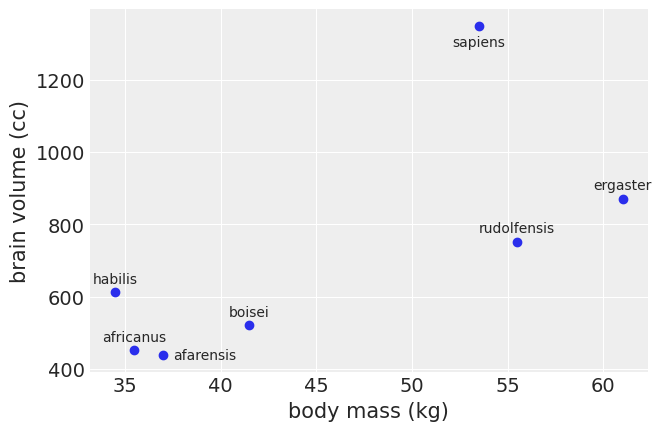

In [4]:
# Figure 7.2

plt.scatter(brains.mass, brains.brain)

# point labels
for i, r in brains.iterrows():
    if r.species == 'afarensis':
        plt.text(r.mass + .5, r.brain, r.species, ha='left', va='center')
    elif r.species == 'sapiens':
        plt.text(r.mass, r.brain - 25, r.species, ha='center', va='top')
    else:
        plt.text(r.mass, r.brain + 25, r.species, ha='center')

plt.xlabel('body mass (kg)')
plt.ylabel('brain volume (cc)')

#### Code 7.2

In [5]:
brains.loc[:, 'mass_std'] = (brains.loc[:, 'mass'] - brains.loc[:, 'mass'].mean()) / brains.loc[:, 'mass'].std()
brains.loc[:, 'brain_std'] = brains.loc[:, 'brain'] / brains.loc[:, 'brain'].max()

#### Code 7.3

Note: in [Chapter 6 of 1st Edition](https://nbviewer.jupyter.org/github/pymc-devs/resources/blob/master/Rethinking/Chp_06.ipynb) (6.2 - 6.6) all these models were done using OLS through statsmodels. I've done them with MCMC here, but it produces significantly larger uncertainties in the fits, so produces quite different LPPD and WAIC numbers.  **Should these be done with MCMC or OLS?**

In [6]:
with pm.Model() as m_7_1:
    mass_std = pm.Data('mass_std', brains.mass_std)  # this is necessary for prediction in 7.10
    a = pm.Normal('a', 0.5, 1)
    b = pm.Normal('b', 0, 10)
    
    mu = pm.Deterministic('mu', a + b * mass_std)
    # The book doesn't say *why* sigma is treated as log_sigma in this model...
    log_sigma = pm.Normal('log_sigma', 0, 1)

    brain_std = pm.Normal('brain_std', mu, pm.math.exp(log_sigma), observed=brains.brain_std)
    
    m_7_1_trace = pm.sample(1000, tune=1000)

az.summary(m_7_1_trace, credible_interval=0.89, var_names=['~mu'])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [log_sigma, b, a]
Sampling 2 chains, 0 divergences: 100%|██████████| 4000/4000 [00:03<00:00, 1138.42draws/s]
The acceptance probability does not match the target. It is 0.8824514061573785, but should be close to 0.8. Try to increase the number of tuning steps.


,mean,sd,hpd_5.5%,hpd_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a,0.527,0.107,0.363,0.677,0.003,0.002,1197.0,1116.0,1363.0,912.0,1.0
b,0.170,0.125,-0.004,0.353,0.004,0.003,1012.0,748.0,1224.0,788.0,1.0
log_sigma,-1.400,0.378,-1.982,-0.831,0.015,0.011,613.0,613.0,665.0,602.0,1.0


#### Code 7.4

In [7]:
p, cov = np.polyfit(brains.loc[:, 'mass_std'], brains.loc[:, 'brain_std'], 1, cov=True)

post = stats.multivariate_normal(p, cov).rvs(1000)

az.summary({k:v for k, v in zip('ba', post.T)}, credible_interval=0.89)

arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


,mean,sd,hpd_5.5%,hpd_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
b,0.167,0.077,0.048,0.294,0.003,0.002,892.0,886.0,898.0,906.0,NaN
a,0.530,0.070,0.432,0.661,0.002,0.002,1055.0,1055.0,1061.0,872.0,NaN


#### Code 7.5

In [8]:
s = pm.sample_posterior_predictive(m_7_1_trace, 1000, m_7_1)
r = np.mean(s['brain_std'], 0) - brains.brain_std
resid_var = np.var(r)
outcome_var = np.var(brains.brain_std)
1 - resid_var / outcome_var  # Calculate R2

/home/oscar/miniconda3/envs/py3/lib/python3.7/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 1000/1000 [00:01<00:00, 560.06it/s]


0.5282150917062397

#### Code 7.6

In [9]:
def R2_is_bad(model, trace, n=1000):
    s = pm.sample_posterior_predictive(trace, n, model)
    key = list(s.keys())[0]  # because we won't automatically know what the predictor is called
    r = np.mean(s[key], 0) - brains.brain_std
    return 1 - np.var(r) / np.var(brains.brain_std)

R2_is_bad(m_7_1, m_7_1_trace)

/home/oscar/miniconda3/envs/py3/lib/python3.7/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 1000/1000 [00:02<00:00, 450.01it/s]


0.484077273434799

#### Code 7.7

In [10]:
with pm.Model() as m_7_2:
    mass_std = pm.Data('mass_std', brains.mass_std)
    a = pm.Normal('a', 0.5, 1)
    b = pm.Normal('b', 0, 10, shape=2)
    
    mu = pm.Deterministic('mu', a + b[0] * mass_std + b[1] * mass_std**2)
    log_sigma = pm.Normal('log_sigma', 0, 1)

    brain_std = pm.Normal('brain_std', mu, pm.math.exp(log_sigma), observed=brains.brain_std)
    
    m_7_2_trace = pm.sample(1000, tune=1000)

az.summary(m_7_2_trace, credible_interval=0.89, var_names=['~mu'])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [log_sigma, b, a]
Sampling 2 chains, 4 divergences: 100%|██████████| 4000/4000 [00:06<00:00, 643.99draws/s]
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


,mean,sd,hpd_5.5%,hpd_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a,0.603,0.246,0.251,0.998,0.009,0.007,724.0,613.0,724.0,653.0,1.01
b[0],0.196,0.157,-0.038,0.440,0.006,0.004,712.0,673.0,726.0,676.0,1.00
b[1],-0.088,0.262,-0.493,0.282,0.010,0.009,713.0,454.0,685.0,703.0,1.00
log_sigma,-1.245,0.415,-1.868,-0.609,0.022,0.016,341.0,341.0,350.0,592.0,1.01


#### Code 7.8

In [11]:
with pm.Model() as m_7_3:
    mass_std = pm.Data('mass_std', brains.mass_std)
    a = pm.Normal('a', 0.5, 1)
    b = pm.Normal('b', 0, 10, shape=3)
    
    mu = pm.Deterministic('mu', (a + b[0] * mass_std + 
                                 b[1] * mass_std**2 + b[2] * mass_std**3))
    log_sigma = pm.Normal('log_sigma', 0, 1)

    brain_std = pm.Normal('brain_std', mu, pm.math.exp(log_sigma), observed=brains.brain_std)

    
    m_7_3_trace = pm.sample(1000, tune=1000)

az.summary(m_7_3_trace, credible_interval=0.89, var_names=['~mu'])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [log_sigma, b, a]
Sampling 2 chains, 6 divergences: 100%|██████████| 4000/4000 [00:08<00:00, 458.27draws/s]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


,mean,sd,hpd_5.5%,hpd_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a,0.547,0.324,0.102,1.053,0.014,0.013,518.0,317.0,551.0,419.0,1.00
b[0],0.413,0.437,-0.306,1.054,0.021,0.015,453.0,453.0,473.0,421.0,1.01
b[1],0.039,0.406,-0.585,0.637,0.019,0.019,463.0,239.0,520.0,367.0,1.00
b[2],-0.213,0.398,-0.802,0.435,0.019,0.015,426.0,366.0,447.0,339.0,1.01
log_sigma,-1.151,0.444,-1.817,-0.467,0.028,0.020,243.0,243.0,285.0,367.0,1.00


In [12]:
with pm.Model() as m_7_4:
    mass_std = pm.Data('mass_std', brains.mass_std)
    a = pm.Normal('a', 0.5, 1)
    b = pm.Normal('b', 0, 10, shape=4)
    
    mu = pm.Deterministic('mu', (a + b[0] * mass_std + 
                                 b[1] * mass_std**2 + b[2] * mass_std**3 + 
                                 b[3] * mass_std**4))
    log_sigma = pm.Normal('log_sigma', 0, 1)

    brain_std = pm.Normal('brain_std', mu, pm.math.exp(log_sigma), observed=brains.brain_std)
    
    m_7_4_trace = pm.sample(1000, tune=1000)

az.summary(m_7_4_trace, credible_interval=0.89, var_names=['~mu'])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [log_sigma, b, a]
Sampling 2 chains, 174 divergences: 100%|██████████| 4000/4000 [00:18<00:00, 212.80draws/s]
There were 58 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6934040929019497, but should be close to 0.8. Try to increase the number of tuning steps.
There were 116 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5859251385590197, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.


,mean,sd,hpd_5.5%,hpd_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a,0.663,0.590,-0.148,1.677,0.052,0.037,129.0,129.0,124.0,349.0,1.03
b[0],0.671,0.970,-0.576,2.171,0.070,0.050,191.0,191.0,172.0,396.0,1.02
b[1],-0.432,1.732,-3.263,1.892,0.138,0.098,157.0,157.0,154.0,332.0,1.03
b[2],-0.544,1.154,-2.255,0.960,0.085,0.060,184.0,184.0,167.0,373.0,1.02
b[3],0.354,1.173,-1.310,2.079,0.091,0.064,166.0,166.0,160.0,406.0,1.03
log_sigma,-0.968,0.445,-1.521,-0.139,0.050,0.048,79.0,43.0,54.0,11.0,1.04


In [13]:
with pm.Model() as m_7_5:
    mass_std = pm.Data('mass_std', brains.mass_std)

    a = pm.Normal('a', 0.5, 1)
    b = pm.Normal('b', 0, 10, shape=5)
    
    mu = pm.Deterministic('mu', (a + b[0] * mass_std + 
                                 b[1] * mass_std**2 + b[2] * mass_std**3 + 
                                 b[3] * mass_std**4 + b[4] * mass_std**5))
    log_sigma = pm.Normal('log_sigma', 0, 1)

    brain_std = pm.Normal('brain_std', mu, pm.math.exp(log_sigma), observed=brains.brain_std)
    
    m_7_5_trace = pm.sample(1000, tune=1000)

az.summary(m_7_5_trace, credible_interval=0.89, var_names=['~mu'])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [log_sigma, b, a]
Sampling 2 chains, 253 divergences: 100%|██████████| 4000/4000 [00:42<00:00, 94.00draws/s] 
There were 136 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6363948925556997, but should be close to 0.8. Try to increase the number of tuning steps.
There were 117 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.659312036556992, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


,mean,sd,hpd_5.5%,hpd_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a,0.747,0.649,-0.439,1.600,0.066,0.046,98.0,98.0,111.0,208.0,1.02
b[0],1.230,1.695,-1.400,3.643,0.125,0.089,183.0,183.0,185.0,278.0,1.02
b[1],-0.284,2.076,-2.872,3.353,0.180,0.128,133.0,133.0,135.0,386.0,1.03
b[2],-1.842,3.517,-6.909,3.722,0.250,0.184,198.0,184.0,206.0,231.0,1.03
b[3],0.028,1.723,-2.672,2.312,0.118,0.084,212.0,212.0,192.0,442.0,1.02
b[4],0.674,1.824,-1.977,3.416,0.120,0.096,230.0,179.0,233.0,250.0,1.04
log_sigma,-0.922,0.590,-1.849,-0.136,0.155,0.144,14.0,9.0,13.0,41.0,1.15


#### Code 7.9

In [14]:
# chains occasionally fail because this is (intentionally) such a bad model.
with pm.Model() as m_7_6:
    mass_std = pm.Data('mass_std', brains.mass_std)

    a = pm.Normal('a', 0.5, 1)
    b = pm.Normal('b', 0, 10, shape=6)
    
    mu = pm.Deterministic('mu', (a + b[0] * mass_std + 
                                 b[1] * mass_std**2 + b[2] * mass_std**3 + 
                                 b[3] * mass_std**4 + b[4] * mass_std**5 +
                                 b[5] * mass_std**6))
    log_sigma = np.log(0.001)
    
    brain_std = pm.Normal('brain_std', mu, pm.math.exp(log_sigma), observed=brains.brain_std)
    
    m_7_6_trace = pm.sample(1000, tune=1000)

az.summary(m_7_6_trace, credible_interval=0.89, var_names=['~mu'])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [b, a]
Sampling 2 chains, 0 divergences: 100%|██████████| 4000/4000 [02:20<00:00, 28.54draws/s]
The acceptance probability does not match the target. It is 0.8875169157017125, but should be close to 0.8. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


,mean,sd,hpd_5.5%,hpd_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a,0.506,0.008,0.493,0.517,0.001,0.000,214.0,214.0,213.0,218.0,1.01
b[0],0.880,0.014,0.856,0.899,0.001,0.001,221.0,221.0,220.0,252.0,1.01
b[1],1.706,0.038,1.650,1.771,0.003,0.002,213.0,212.0,211.0,236.0,1.01
b[2],-0.608,0.036,-0.662,-0.549,0.002,0.002,218.0,218.0,217.0,238.0,1.01
b[3],-3.483,0.057,-3.583,-3.403,0.004,0.003,213.0,213.0,212.0,239.0,1.01
b[4],-0.350,0.023,-0.385,-0.312,0.002,0.001,217.0,216.0,214.0,246.0,1.01
b[5],1.629,0.026,1.592,1.674,0.002,0.001,213.0,213.0,213.0,281.0,1.01


#### Code 7.10

The chapter gives code to produce the first panel of Figure 7.3. Here, produce the entire figure by looping over models 7.1-7.6.

To sample the posterior predictive on a new independent variable we make use of theano SharedVariable objects, as outlined [here](https://docs.pymc.io/notebooks/data_container.html)

100%|██████████| 2000/2000 [00:09<00:00, 209.71it/s]


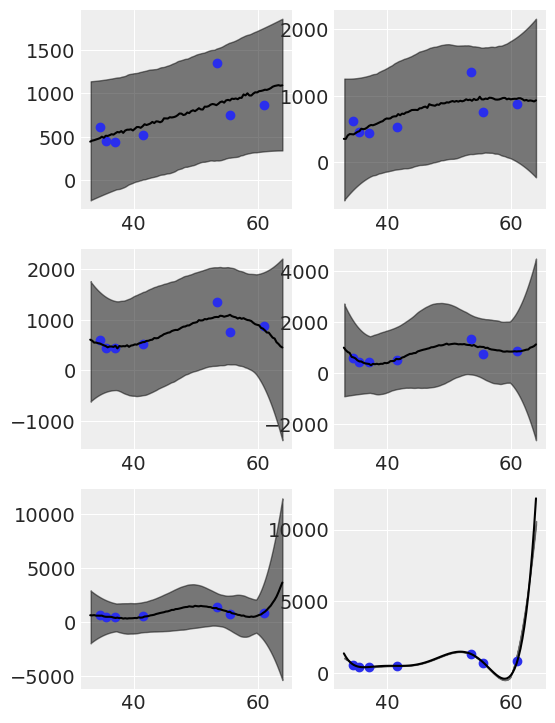

In [15]:
models = [m_7_1, m_7_2, m_7_3, m_7_4, m_7_5, m_7_6]
traces = [m_7_1_trace, m_7_2_trace, m_7_3_trace, m_7_4_trace, m_7_5_trace, m_7_6_trace]
nsamples = 2000

mass_plot = np.linspace(33, 64, 100)
mass_new = (mass_plot - brains.mass.mean()) / brains.mass.std()

# sample posterior predictive
post_preds = []
for model, trace in zip(models, traces):
    with model:
        pm.set_data({'mass_std': mass_new})  # update shared variable with predictive independent variable
        post_preds.append(pm.sample_posterior_predictive(trace, samples=nsamples)['brain_std'])
        
# draw plot
fig, axs = plt.subplots(3, 2, figsize=[6, 9])

for ax, post_pred in zip(axs.flat, post_preds):
    post_pred *= brains.brain.max()  # scale back to original data
    az.plot_hpd(mass_plot, post_pred, credible_interval=0.89, ax=ax, color='k', smooth=True)
    ax.plot(mass_plot, np.mean(post_pred, 0), color='k')
    
    ax.scatter(brains.mass, brains.brain)

Much larger uncertainties than in the book because we're using MCMC posterior prediction, rather than OLS.

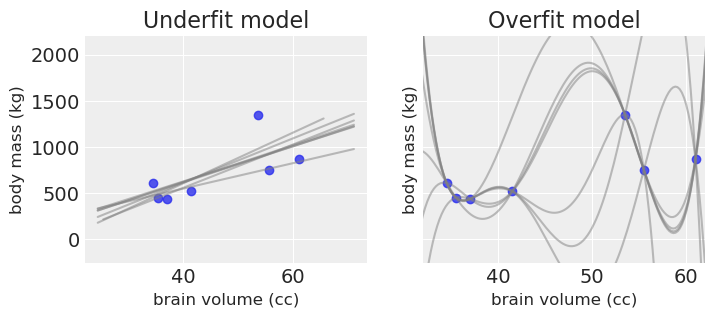

In [16]:
# Figure 7.4

# this code taken from PyMC3 port of Rethinking/Chp_06.ipynb

f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(8,3))
ax1.scatter(brains.mass, brains.brain, alpha=0.8)
ax2.scatter(brains.mass, brains.brain, alpha=0.8)
for i in range(len(brains)):
    d_new = brains.drop(brains.index[-i])
    m0 = smf.ols('brain ~ mass', d_new).fit()
    # need to calculate regression line
    # need to add intercept term explicitly
    x = sm.add_constant(d_new.mass)  # add constant to new data frame with mass
    x_pred = pd.DataFrame({'mass': np.linspace(x.mass.min() - 10, x.mass.max() + 10, 50)})  # create linspace dataframe
    x_pred2 = sm.add_constant(x_pred)  # add constant to newly created linspace dataframe
    y_pred = m0.predict(x_pred2)  # calculate predicted values
    ax1.plot(x_pred, y_pred, 'gray', alpha=.5)
    ax1.set_ylabel('body mass (kg)', fontsize=12);
    ax1.set_xlabel('brain volume (cc)', fontsize=12)
    ax1.set_title('Underfit model')
    
    # fifth order model
    m1 = smf.ols('brain ~ mass + I(mass**2) + I(mass**3) + I(mass**4) + I(mass**5)', data=d_new).fit()
    x = sm.add_constant(d_new.mass)  # add constant to new data frame with mass
    x_pred = pd.DataFrame({'mass': np.linspace(x.mass.min()-10, x.mass.max()+10, 200)})  # create linspace dataframe
    x_pred2 = sm.add_constant(x_pred)  # add constant to newly created linspace dataframe
    y_pred = m1.predict(x_pred2)  # calculate predicted values from fitted model
    ax2.plot(x_pred, y_pred, 'gray', alpha=.5)
    ax2.set_xlim(32,62)
    ax2.set_ylim(-250, 2200)
    ax2.set_ylabel('body mass (kg)', fontsize=12);
    ax2.set_xlabel('brain volume (cc)', fontsize=12)
    ax2.set_title('Overfit model')

#### Code 7.11 - this is R specific notation for dropping rows

In [17]:
brains_new = brains.drop(brains.index[-1])

#### Code 7.12

In [18]:
p = np.array([0.3, 0.7])
-np.sum(p * np.log(p))

0.6108643020548935

Text(0.315, 1.22, 'q = p')

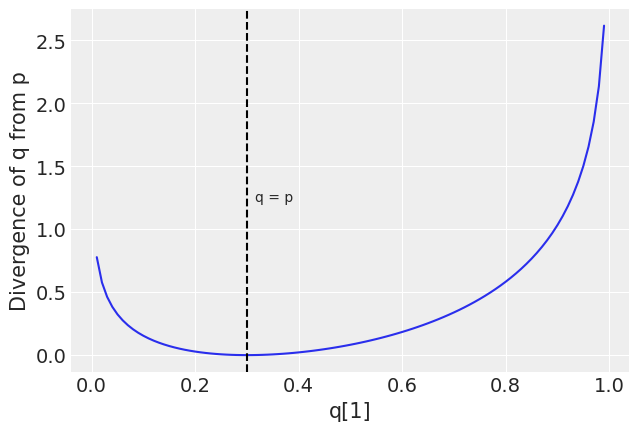

In [19]:
# Figure 7.5
p = np.array([0.3, 0.7])
q = np.arange(0.01, 1, 0.01)
DKL = np.sum(p * np.log(p / np.array([q, 1-q]).T), 1)

plt.plot(q, DKL)
plt.xlabel('q[1]')
plt.ylabel('Divergence of q from p')
plt.axvline(0.3, ls='dashed', color='k')
plt.text(0.315, 1.22, 'q = p')

#### Code 7.13 & 7.14

In [20]:
from scipy.special import logsumexp

In [21]:
# does PyMC3 have a way to give us lppd directly?

n_samples = 3000

with m_7_1:
    pm.set_data({'mass_std': brains.mass_std})
    post_pred = pm.sample_posterior_predictive(m_7_1_trace, n_samples, var_names=['log_sigma', 'brain_std'])

ns, n = post_pred['brain_std'].shape

# this approach for calculating lppd isfrom 7.14
ll = np.zeros((n, ns))
for s in range(ns):
    logprob = stats.norm.logpdf(brains.brain_std, post_pred['brain_std'][s], np.exp(post_pred['log_sigma'][s]))  # this does the work of `sim`
    ll[:, s] = logprob

lppd = np.zeros(n)
for i in range(n):
    lppd[i] = logsumexp(ll[i]) - np.log(ns)

lppd

100%|██████████| 3000/3000 [00:03<00:00, 777.58it/s]


array([ 0.13441005,  0.12393539,  0.07522894,  0.13329529,  0.05264047,
        0.01941231, -0.49745341])

These values are all lower than the book. Presumably this is because our credible interval is so much wider?

#### Code 7.15

In [23]:
m_7_6.vars

[a, b]

In [24]:
# make an lppd function that can be applied to all models (from code above)
def lppd(model, trace, n_samples=1e4):
    n_samples = int(n_samples)
    
    pm.set_data({'mass_std': brains.mass_std}, model)
    if 'log_sigma' in model.vars:
        post_pred = pm.sample_posterior_predictive(trace, n_samples, model, var_names=['log_sigma', 'brain_std'])
    else:
        post_pred = pm.sample_posterior_predictive(trace, n_samples, model, var_names=['brain_std'])
        post_pred['log_sigma'] = np.full(n_samples, np.log(0.001))

    ns, n = post_pred['brain_std'].shape

    # this approach for calculating lppd isfrom 7.14
    ll = np.zeros((n, ns))
    for s in range(ns):
        logprob = stats.norm.logpdf(brains.brain_std, post_pred['brain_std'][s], np.exp(post_pred['log_sigma'][s]))  # this does the work of `sim`
        ll[:, s] = logprob

    lppd = np.zeros(n)
    for i in range(n):
        lppd[i] = logsumexp(ll[i]) - np.log(ns)

    return lppd

In [25]:
lppds = np.array(list(map(lppd, models, traces, [1000] * len(models))))

lppds.sum(1)

/home/oscar/miniconda3/envs/py3/lib/python3.7/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 1000/1000 [00:01<00:00, 515.61it/s]


array([ 2.03540585,  0.84443281,  1.01746652, -8.08583455,  0.70023777,
       38.11195674])

#### Code 7.16

This relies on the `sim.train.test` function in the `rethinking` package. [This](https://github.com/rmcelreath/rethinking/blob/master/R/sim_train_test.R) is the original function.

The python port of this function below is from [Rethinking/Chp_06](https://nbviewer.jupyter.org/github/pymc-devs/resources/blob/master/Rethinking/Chp_06.ipynb) Code 6.12.

In [26]:
def sim_train_test(N=20, k=3, rho=[0.15, -0.4], b_sigma=100):
    
    n_dim = 1 + len(rho)
    if n_dim < k:
        n_dim = k
    Rho = np.diag(np.ones(n_dim))
    Rho[0, 1:3:1] = rho
    i_lower = np.tril_indices(n_dim, -1)
    Rho[i_lower] = Rho.T[i_lower]
    
    x_train = stats.multivariate_normal.rvs(cov=Rho, size=N)
    x_test = stats.multivariate_normal.rvs(cov=Rho, size=N)
    
    mm_train = np.ones((N,1))
    
    np.concatenate([mm_train, x_train[:, 1:k]], axis=1)
    
    #Using pymc3
    
    with pm.Model() as m_sim:
        vec_V = pm.MvNormal('vec_V', mu=0, cov=b_sigma * np.eye(n_dim), 
                            shape=(1, n_dim), testval=np.random.randn(1, n_dim)*.01)
        mu = pm.Deterministic('mu', 0 + pm.math.dot(x_train, vec_V.T))
        y = pm.Normal('y', mu=mu, sd=1, observed=x_train[:, 0])

    with m_sim:
        trace_m_sim = pm.sample()
        
    vec = pm.summary(trace_m_sim)['mean'][:n_dim]
    vec = np.array([i for i in vec]).reshape(n_dim, -1)
    
    dev_train = - 2 * sum(stats.norm.logpdf(x_train, loc = np.matmul(x_train, vec), scale = 1))    
    
    mm_test = np.ones((N,1))
    
    mm_test = np.concatenate([mm_test, x_test[:, 1:k +1]], axis=1)
    
    dev_test = - 2 * sum(stats.norm.logpdf(x_test[:,0], loc = np.matmul(mm_test, vec), scale = 1))    
    
    return np.mean(dev_train), np.mean(dev_test)

In [27]:
n = 20
tries = 10
param = 6
r = np.zeros(shape=(param - 1, 4))

train = []
test = []

for j in range(2, param + 1):
    print(j)
    for i in range(1, tries + 1):
        tr, te = sim_train_test(N=n, k=param)
        train.append(tr), test.append(te)
    r[j -2, :] = np.mean(train), np.std(train, ddof=1), np.mean(test), np.std(test, ddof=1)

2


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [vec_V]
Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:02<00:00, 739.70draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [vec_V]
Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:03<00:00, 648.01draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [vec_V]
Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:02<00:00, 785.42draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [vec_V]
Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:02<00:00, 672.84draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains 

3


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [vec_V]
Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:02<00:00, 766.26draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [vec_V]
Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:02<00:00, 764.49draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [vec_V]
Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:03<00:00, 629.74draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [vec_V]
Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:02<00:00, 671.55draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains 

4


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [vec_V]
Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:04<00:00, 474.50draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [vec_V]
Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:04<00:00, 426.33draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [vec_V]
Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:03<00:00, 613.59draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [vec_V]
Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:03<00:00, 548.19draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains 

5


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [vec_V]
Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:03<00:00, 627.04draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [vec_V]
Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:03<00:00, 558.55draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [vec_V]
Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:03<00:00, 529.09draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [vec_V]
Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:03<00:00, 599.22draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains 

6


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [vec_V]
Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:03<00:00, 589.14draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [vec_V]
Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:03<00:00, 590.95draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [vec_V]
Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:04<00:00, 422.42draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [vec_V]
Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:03<00:00, 576.52draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains 

#### Code 7.17

In [28]:
# multithreading is automatic in PyMC3?

#### Code 7.18

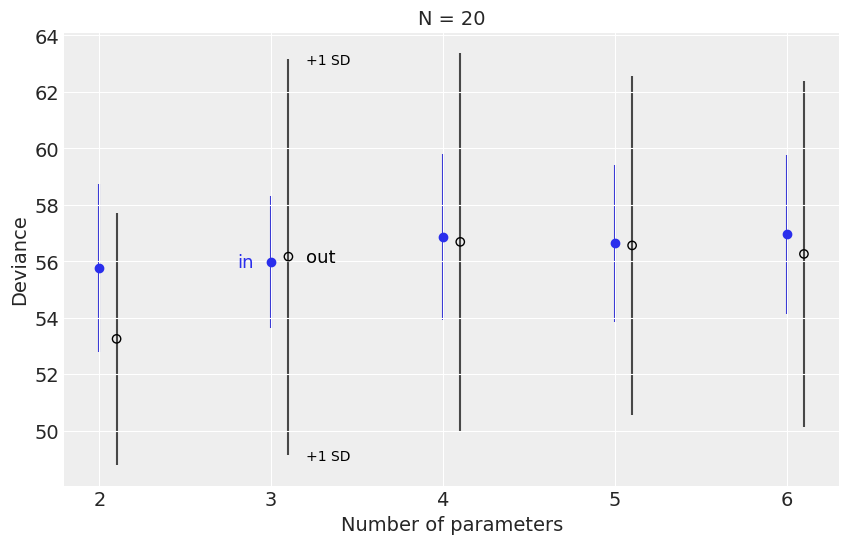

In [29]:
num_param = np.arange(2, param + 1)

plt.figure(figsize=(10, 6))
plt.scatter(num_param, r[:, 0], color='C0')
plt.xticks(num_param)

for j in range(param - 1):
    plt.vlines(num_param[j], r[j,0] - r[j, 1], r[j,0] + r[j,1], color='mediumblue', 
               zorder=-1, alpha=0.80)

plt.scatter(num_param + 0.1, r[:, 2], facecolors='none', edgecolors='k')

for j in range(param - 1):
    plt.vlines(num_param[j] + 0.1, r[j,2] - r[j, 3], r[j,2] + r[j,3], color='k', 
               zorder=-2, alpha=0.70)    

dist = 0.20
plt.text(num_param[1] - dist, r[1, 0] - dist, 'in', color='C0', fontsize=13)
plt.text(num_param[1] + dist, r[1, 2] - dist, 'out', color='k', fontsize=13)
plt.text(num_param[1] + dist, r[1, 2] + r[1,3] - dist, '+1 SD', color='k', fontsize=10)
plt.text(num_param[1] + dist, r[1, 2] - r[1,3] - dist, '+1 SD', color='k', fontsize=10)
plt.xlabel('Number of parameters', fontsize=14)
plt.ylabel('Deviance', fontsize=14)
plt.title('N = {}'.format(n), fontsize=14)
plt.show()

These uncertainties are a *lot* larger than in the book... MCMC vs OLS again?

#### Code 7.19

7.19 to 7.25 transcribed directly from 6.15-6.20 in [Chapter 6 of 1st Edition](https://nbviewer.jupyter.org/github/pymc-devs/resources/blob/master/Rethinking/Chp_06.ipynb).

In [30]:
data = pd.read_csv('Data/cars.csv', sep=',', index_col=0)

In [31]:
with pm.Model() as m :
    a = pm.Normal('a', mu=0, sd=100)
    b = pm.Normal('b', mu=0, sd=10)
    sigma = pm.Uniform('sigma', 0, 30)
    mu = pm.Deterministic('mu', a + b * data['speed'])
    dist = pm.Normal('dist', mu=mu, sd=sigma, observed = data['dist'])
    m = pm.sample(5000, tune=10000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, b, a]
Sampling 2 chains, 0 divergences: 100%|██████████| 30000/30000 [00:40<00:00, 745.77draws/s]
The acceptance probability does not match the target. It is 0.6942847930376241, but should be close to 0.8. Try to increase the number of tuning steps.


#### Code 7.20

In [32]:
n_samples = 1000
n_cases = data.shape[0]
logprob = np.zeros((n_cases, n_samples))

for s in range(0, n_samples):
    mu = m['a'][s] + m['b'][s] * data['speed']
    p_ = stats.norm.logpdf(data['dist'], loc=mu, scale=m['sigma'][s])
    logprob[:,s] = p_

#### Code 7.21

In [33]:
n_cases = data.shape[0]
lppd = np.zeros((n_cases))
for a in range(1, n_cases):
    lppd[a,] = logsumexp(logprob[a,]) - np.log(n_samples)

#### Code 7.22

In [34]:
pWAIC = np.zeros((n_cases))
for i in range(1, n_cases):
    pWAIC[i,] = np.var(logprob[i,])

#### Code 7.23

In [35]:
- 2 * (sum(lppd) - sum(pWAIC))

412.29893684136545

#### Code 7.24

In [36]:
waic_vec = - 2 * (lppd - pWAIC)
(n_cases * np.var(waic_vec))**0.5

15.096309174348482

#### Setup for Code 7.25+

Have to reproduce m6.6-m6.8 from Code 6.13-6.17 in Chapter 6

In [37]:
# d = pd.read_csv('Data/milk.csv', sep=';')
# d['neocortex'] = d['neocortex.perc'] / 100
# d.dropna(inplace=True)

# number of plants
N = 100
# simulate initial heights
h0 = np.random.normal(10, 2, N)
# assign treatments and simulate fungus and growth
treatment = np.repeat([0,1], N/2)
fungus = np.random.binomial(n=1, p=0.5 - treatment * 0.4, size=N)
h1 = h0 + np.random.normal(5 - 3 * fungus, size=N)
# compose a clean data frame
d = pd.DataFrame.from_dict({'h0': h0, 'h1': h1, 'treatment': treatment, 'fungus': fungus})

with pm.Model() as m_6_6:
    p = pm.Lognormal('p', 0, 0.25)
    
    mu = pm.Deterministic('mu', p * d.h0)
    sigma = pm.Exponential('sigma', 1)
    
    h1 = pm.Normal('h1', mu=mu, sigma=sigma, observed=d.h1)
    
    m_6_6_trace = pm.sample()

with pm.Model() as m_6_7:
    a = pm.Normal('a', 0, 0.2)
    bt = pm.Normal('bt', 0, 0.5)
    bf = pm.Normal('bf', 0, 0.5)
    
    p = a + bt * d.treatment + bf * d.fungus
    
    mu = pm.Deterministic('mu', p * d.h0)
    sigma = pm.Exponential('sigma', 1)
    
    h1 = pm.Normal('h1', mu=mu, sigma=sigma, observed=d.h1)
    
    m_6_7_trace = pm.sample()

with pm.Model() as m_6_8:
    a = pm.Normal('a', 0, 0.2)
    bt = pm.Normal('bt', 0, 0.5)
    
    p = a + bt * d.treatment
    
    mu = pm.Deterministic('mu', p * d.h0)
    sigma = pm.Exponential('sigma', 1)
    
    h1 = pm.Normal('h1', mu=mu, sigma=sigma, observed=d.h1)
    
    m_6_8_trace = pm.sample()



Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, p]
Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1208.33draws/s]
The acceptance probability does not match the target. It is 0.8837999701289947, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, bf, bt, a]
Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:02<00:00, 766.30draws/s]
The acceptance probability does not match the target. It is 0.8894395987077259, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, bt, a]
Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:02<00:00, 943.31draws/s] 


#### Code 7.25

In [38]:
az.waic(m_6_7_trace, m_6_7, scale='deviance')

Computed from 1000 by 100 log-likelihood matrix

              Estimate       SE
deviance_waic   352.97    12.08
p_waic            3.18        -

#### Code 7.26

In [39]:
compare_df = az.compare({'m_6_6' : m_6_6_trace,
                         'm_6_7' : m_6_7_trace,
                         'm_6_8' : m_6_8_trace,}, method='pseudo-BMA', ic='waic', scale='deviance')
compare_df

,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
m_6_7,0,352.974,3.17921,0,1,12.0838,0,False,deviance
m_6_8,1,410.961,2.53352,57.9877,2.55932e-13,11.7274,10.1445,False,deviance
m_6_6,2,413.79,1.78948,60.8167,6.22048e-14,11.7148,11.2553,False,deviance


#### Code 7.27

I don't understand this code block in the book. First, it calls `waic_m6.6`, which isn't defined until 7.30. Next, it asks for the length of `waic_m6.6`, although it seems from the `diff_` output that these are all of length 1. Finally, I'm not sure what parameters `az.waic` needs to produce the same numbers as the `rethinking` `WAIC` function. From the above we get similar numbers when `scale='deviance'`, but in this block it produces a completely different number (-71 here vs 10 in the book).

`pointwise=True` isn't doing what I expect it to. I would expect the function to return an array the same length as the data.

What have I done wrong?

In [40]:
waic_m_6_7 = az.waic(m_6_7_trace, pointwise=True, scale='deviance')
waic_m_6_8 = az.waic(m_6_8_trace, pointwise=True, scale='deviance')

waic_m_6_7.waic - waic_m_6_8.waic

-57.987728303370034

#### Code 7.28

In [41]:
40.0 + np.array([-1, 1]) * 10.4 * 2.6

array([12.96, 67.04])

#### Code 7.29

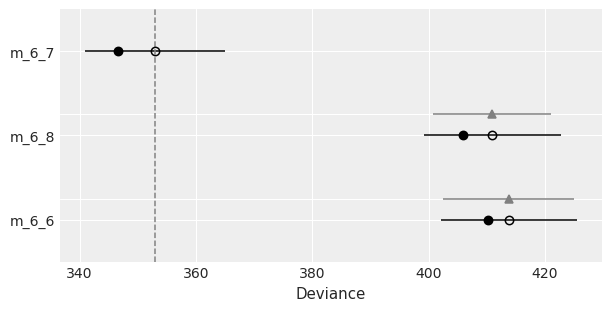

In [42]:
az.plot_compare(compare_df)

#### Code 7.30

As with 7.27, can't make sense of this.

In [43]:
waic_m_6_6 = az.waic(m_6_6_trace, pointwise=True, scale='deviance')

diff_m6_6_m6_8 = waic_m_6_6.waic - waic_m_6_8.waic

np.sqrt(1 * np.var( diff_m6_6_m6_8))

0.0

#### Code 7.31

dSE is calculated by compare above, but `rethinking` produces a pairwise comparison.

Note: the **must** be a better way to do this.

In [44]:
ms = {'m_6_6' : m_6_6_trace,
      'm_6_7' : m_6_7_trace,
      'm_6_8' : m_6_8_trace}

# this is ugly, but I can'y see a clear way to calculate pairwise WAIC dSE using az.

dSEs = pd.DataFrame(columns=ms.keys(), index=ms.keys())

for k in ms.keys():
    for l in ms.keys():
        if k == l:
            continue
        comp = az.compare({k: ms[k], l: ms[l]}, method='pseudo-BMA', ic='waic', scale='deviance')
        dSEs.loc[k, l] = max(comp.loc[:, 'dse'])

In [45]:
# these numbers are quite different from those in the book
dSEs

,m_6_6,m_6_7,m_6_8
m_6_6,NaN,11.2553,6.20414
m_6_7,11.2553,NaN,10.1445
m_6_8,6.20414,10.1445,NaN


#### Code 7.32

In [46]:
d = pd.read_csv('Data/Primates301.csv', sep=';')

#### Code 7.33

In [47]:
def scale(x):
    return (x - np.nanmean(x)) / np.nanstd(x)

d.loc[:, 'log_L'] = scale(np.log(d.loc[:, 'longevity']))
d.loc[:, 'log_B'] = scale(np.log(d.loc[:, 'brain']))
d.loc[:, 'log_M'] = scale(np.log(d.loc[:, 'body']))

#### Code 7.34

In [48]:
d.loc[:, ['log_L', 'log_B', 'log_M']].isna().sum()

log_L    181
log_B    117
log_M     63
dtype: int64

#### Code 7.35

In [49]:
ind = np.all(~d.loc[:, ['log_L', 'log_B', 'log_M']].isna(), 1)
d2 = d.loc[ind]
d2.shape

(112, 19)

#### Code 7.36

In [50]:
with pm.Model() as m_7_8:
    a = pm.Normal('a', 0, 0.1)
    bM = pm.Normal('bM', 0, 0.5)
    bB = pm.Normal('bB', 0, 0.5)
    
    mu = a + bM * d2.log_M + bB * d2.log_B
    sigma = pm.Exponential('sigma', 1)
    
    log_L = pm.Normal('log_L', mu, sigma, observed=d2.log_L)
    
    m_7_8_trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, bB, bM, a]
Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:04<00:00, 464.21draws/s]
The acceptance probability does not match the target. It is 0.8914651944965659, but should be close to 0.8. Try to increase the number of tuning steps.


#### Code 7.37

In [51]:
with pm.Model() as m_7_9:
    a = pm.Normal('a', 0, 0.1)
    bB = pm.Normal('bB', 0, 0.5)
    
    mu = a + bB * d2.log_B
    sigma = pm.Exponential('sigma', 1)
    
    log_L = pm.Normal('log_L', mu, sigma, observed=d2.log_L)
    
    m_7_9_trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, bB, a]
Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1114.66draws/s]
The acceptance probability does not match the target. It is 0.8804053652072463, but should be close to 0.8. Try to increase the number of tuning steps.


In [52]:
with pm.Model() as m_7_10:
    a = pm.Normal('a', 0, 0.1)
    bM = pm.Normal('bM', 0, 0.5)
    
    mu = a + bM * d2.log_M
    sigma = pm.Exponential('sigma', 1)
    
    log_L = pm.Normal('log_L', mu, sigma, observed=d2.log_L)
    
    m_7_10_trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, bM, a]
Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1144.03draws/s]


#### Code 7.38

In [53]:
compare_df = az.compare({'m_7_8' : m_7_8_trace,
                         'm_7_9' : m_7_9_trace,
                         'm_7_10' : m_7_10_trace,}, method='pseudo-BMA', ic='waic', scale='deviance')
compare_df

,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
m_7_9,0,217.102,2.3517,0,0.519302,14.1783,0,False,deviance
m_7_8,1,217.259,3.2983,0.157101,0.480072,13.9811,1.23797,False,deviance
m_7_10,2,230.543,2.48639,13.4409,0.000626269,15.7009,5.42153,False,deviance


#### Code 7.39

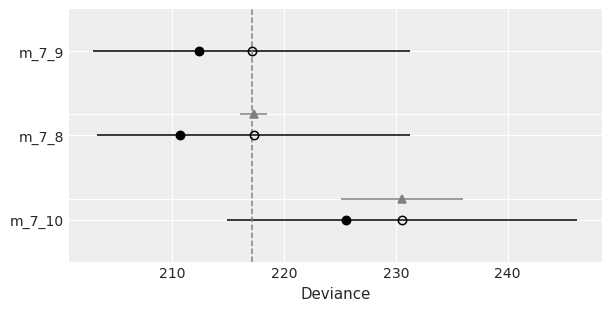

In [54]:
az.plot_compare(compare_df)

#### Code 7.40

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fb7b670ac10>],
      dtype=object)

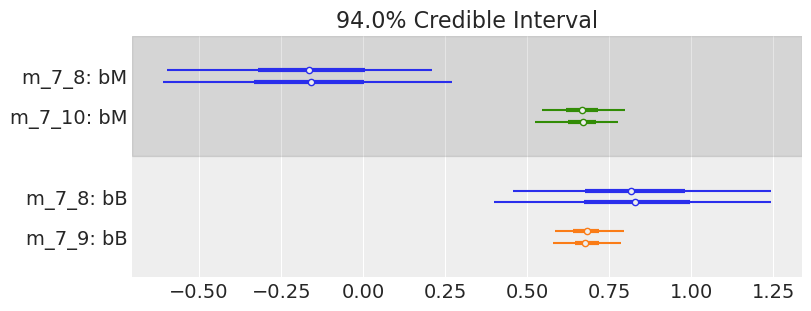

In [55]:
traces = [m_7_8_trace, m_7_9_trace, m_7_10_trace]
az.plot_forest(traces, model_names=['m_7_8', 'm_7_9', 'm_7_10'], var_names=['bM', 'bB'], figsize=[8, 3])

#### Code 7.41

In [56]:
np.corrcoef(d2.log_B, d2.log_M)

array([[1.        , 0.97962718],
       [0.97962718, 1.        ]])

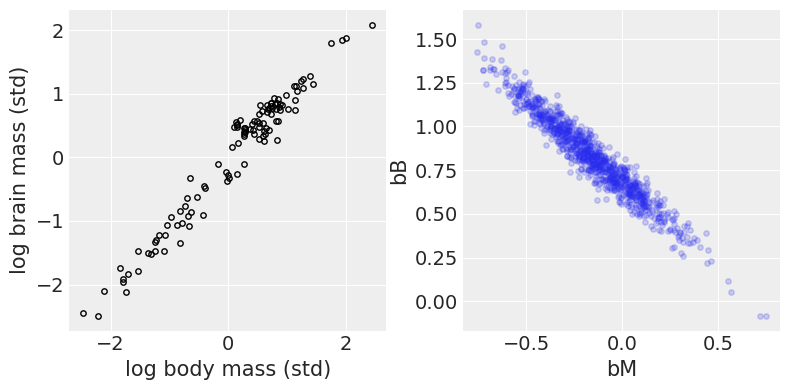

In [57]:
# Figure 7.10

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[8, 4])

ax1.scatter(d2.log_M, d2.log_B, s=15, facecolor=(0,0,0,0), edgecolor='k')
ax1.set_xlabel('log body mass (std)')
ax1.set_ylabel('log brain mass (std)')

ax2.scatter(m_7_8_trace[bM], m_7_8_trace[bB], alpha=0.2, s=15)
ax2.set_xlabel('bM')
ax2.set_ylabel('bB')

fig.tight_layout()

#### Code 7.42

In [58]:
# why doesn't pointwise=True produce a pointwise result? Output is identical when True or False!
waic_m_7_8 = az.waic(m_7_8_trace, pointwise=True)
waic_m_7_9 = az.waic(m_7_9_trace, pointwise=True)

#### Code 7.43

In [59]:
# compute point scaling
x = d2.log_B - d2.log_M
x -= x.min()
x /= x.max()

# can't draw plot until 7.42 issue is solved.

#### Code 7.44

In [60]:
with pm.Model() as m_7_11:
    a = pm.Normal('a', 0, 0.1)
    bM = pm.Normal('bM', 0, 0.5)
    bL = pm.Normal('bL', 0, 0.5)

    mu = a + bM * d2.log_M + bL * d2.log_L
    sigma = pm.Exponential('sigma', 1)

    log_L = pm.Normal('log_L', mu, sigma, observed=d2.log_B)

    m_7_11_trace = pm.sample(tune=1000)

az.summary(m_7_11_trace)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, bL, bM, a]
Sampling 2 chains, 0 divergences: 100%|██████████| 3000/3000 [00:02<00:00, 1022.36draws/s]


,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a,-0.045,0.019,-0.081,-0.009,0.001,0.000,830.0,806.0,827.0,640.0,1.00
bM,0.938,0.028,0.882,0.988,0.001,0.001,719.0,719.0,707.0,593.0,1.00
bL,0.116,0.030,0.063,0.172,0.001,0.001,727.0,700.0,729.0,696.0,1.01
sigma,0.196,0.014,0.173,0.226,0.000,0.000,814.0,810.0,818.0,789.0,1.00
